# California Housing Prices

In [215]:
import os
import shap
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted

warnings.filterwarnings('ignore')

In [19]:
PATH = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(PATH)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [22]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


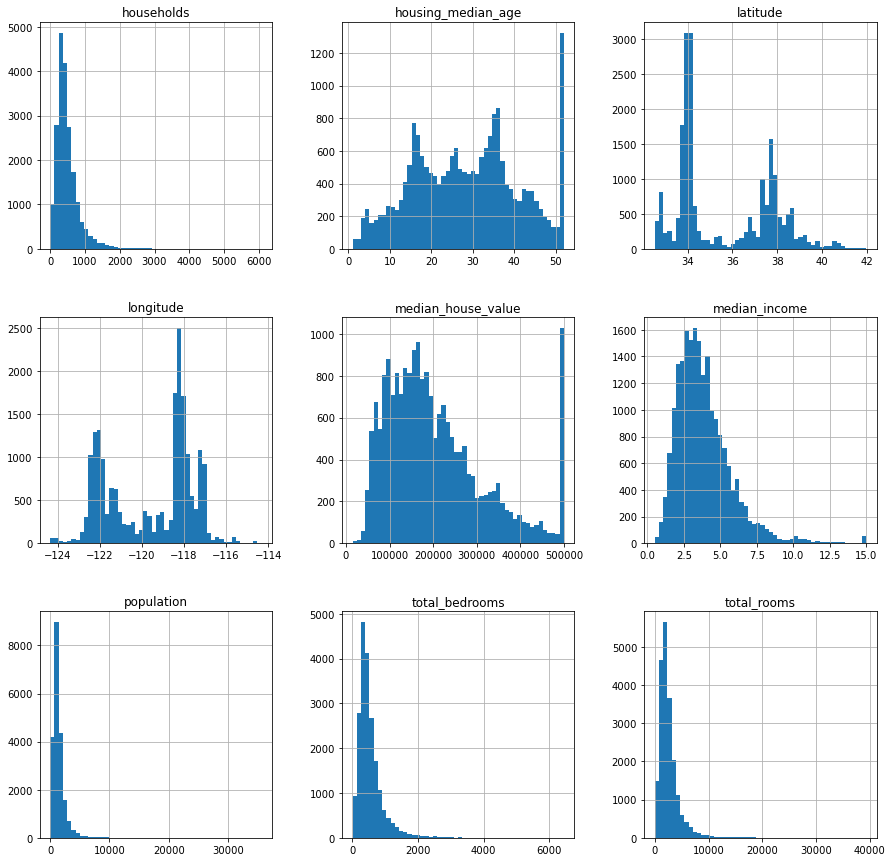

In [23]:
df.hist(bins=50, figsize=(15,15));

In [33]:
df = df.loc[df.median_house_value<=500000]

In [165]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

X_train = train_df.drop(['median_house_value'], axis=1).copy()
y_train = train_df['median_house_value'].values

X_test = test_df.drop(['median_house_value'], axis=1).copy()
y_test = test_df['median_house_value'].values

In [39]:
def plot_corr_map(data, center=None):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = data.corr()
    hm = sns.heatmap(round(corr, 2),
                     annot=True,
                     ax=ax,
                     cmap="coolwarm",
                     fmt='.2f',
                     linewidths=.05,
                     center=center)
    f.subplots_adjust(top=0.93)
    t = f.suptitle('User Data Correlation Heatmap', fontsize=16)
    return f

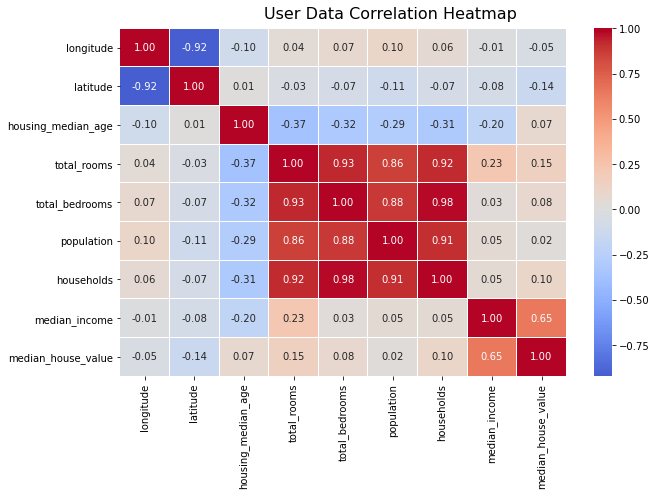

In [49]:
fig1 = plot_corr_map(train_df, center=0)

General ->
* remove heavily correlated features

Numerical features ->
* impute median value for missing
* Standard scale features
* power transform features (optional)

Caetgorical features ->
* One hot encoder or Ordinal encoder
* Standard scale

In [287]:
class DropFeatures(BaseEstimator, TransformerMixin):
    '''Drop features by specifying which ones to drop'''
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        if self.features_to_drop:
            X_r = X.copy()
            X_r = X_r.drop(self.features_to_drop, axis=1)
            self.feature_mask = ~X.columns.isin(self.features_to_drop)
            return X_r
        else:
            return X

In [273]:
class RegressorSelector(BaseEstimator):
    '''Choose model for regression'''
    def __init__(self, estimator = LinearRegression()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        check_is_fitted(self.estimator)
        return self.estimator.predict(X)

In [275]:
def cv_score_statistics(estimator, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print('All scores:\n', np.sort(scores), '\n')
    print('Mean:', np.round(np.mean(scores), 3))
    print('SD:', np.round(np.std(scores), 3))

In [276]:
num_features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

In [277]:
cat_features = ['ocean_proximity']

In [288]:
pipeline = Pipeline(steps=[
    ('dropper', DropFeatures()),
    ('process', ColumnTransformer(transformers=[
        ('num_process', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat_process', OneHotEncoder(drop='first'), cat_features)
    ])),
    ('regress', RegressorSelector())
])

**Baseline**

In [281]:
cv_score_statistics(pipeline, X_train, y_train)

All scores:
 [-63247.8491134  -61468.68826589 -61125.92107275 -60717.39671672
 -60716.97628868] 

Mean: -61455.366
SD: 939.311


In [178]:
params = [
    {
        'dropper__features_to_drop': [['total_rooms', 'total_bedrooms', 'population'], ['total_rooms', 'total_bedrooms', 'households'], ['total_rooms', 'households', 'population'], ['households', 'total_bedrooms', 'population'], None],
        'regress__estimator': [LinearRegression(), Ridge(), ElasticNet(), KNeighborsRegressor(), RandomForestRegressor(), SVR()]
    }
]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'dropper__features_to_drop': ['households', 'total_bedrooms', 'population'], 'regress__estimator': RandomForestRegressor()}
Best score: -45361.779009881895


In [179]:
cv_score_statistics(grid.best_estimator_, X_train, y_train)

All scores:
 [-47901.8652182  -45470.67575092 -45314.21023116 -44689.67694173
 -43706.92309011] 

Mean: -45416.67
SD: 1388.623


In [289]:
params = [
    {
        'dropper__features_to_drop': [['households', 'total_bedrooms', 'population']],
        'regress__estimator': [RandomForestRegressor()],
        'regress__estimator__n_estimators': [50, 100, 500],
        'regress__estimator__min_samples_leaf': [0.0002],
        'regress__estimator__max_features': [2, 4, 6, 8],
    }
]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'dropper__features_to_drop': ['households', 'total_bedrooms', 'population'], 'regress__estimator': RandomForestRegressor(max_features=8, min_samples_leaf=0.0002, n_estimators=500), 'regress__estimator__max_features': 8, 'regress__estimator__min_samples_leaf': 0.0002, 'regress__estimator__n_estimators': 500}
Best score: -45239.97810760619


In [290]:
cv_score_statistics(grid.best_estimator_, X_train, y_train)

All scores:
 [-47205.43312251 -45570.16525299 -45039.34406917 -44297.93081174
 -44047.54155198] 

Mean: -45232.083
SD: 1124.396


**Test Set:**

In [291]:
y_pred = grid.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

RMSE: 44623.7708328146
MAE:  30128.003753057812


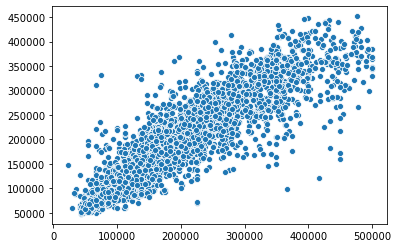

In [292]:
sns.scatterplot(y=y_pred, x=y_test)

In [310]:
importances = grid.best_estimator_['regress'].estimator.feature_importances_

In [322]:
selected_features = X_train.columns.values[grid.best_estimator_['dropper'].feature_mask]
selected_features = selected_features[~np.isin(selected_features, cat_features)]
selected_features = np.append(selected_features, grid.best_estimator_['process'].named_transformers_['cat_process'].get_feature_names())

In [323]:
imp = pd.DataFrame({'feature': selected_features, 'importance': importances})
imp = imp.sort_values(by='importance', ascending=False)

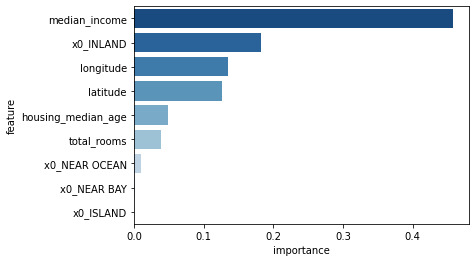

In [324]:
sns.barplot(x='importance', y='feature', data=imp, orient='h', palette='Blues_r');

KeyError: "['x0_NEAR BAY', 'x0_ISLAND', 'x0_INLAND', 'x0_NEAR OCEAN'] not in index"

In [334]:
preprocessor = grid.best_estimator_[0:2]
X_train_pp = preprocessor.fit_transform(X_train)
pd.DataFrame(X_train)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(grid.best_estimator_['regress'].estimator)
shap_values = np.array(explainer.shap_values(X_train_pp))